## Mahindra First Choice Data Analysis

### Problem Statements
    1. Geolocation Based Customer Analysis
        * Explore how various factors like make, model, time & type of service, etc vary with location.
            * Identifying the ownership pattern of cars throughout the country.
            * This also captures the problem wherein information regarding the spending patterns can be identified.
        * Identify the type of order each state receives and present it as an interactive visualization.
    2. Market Segmentation
        * Divide market of potential customers into internally homogeneous and mutually heterogeneous groups or segments.
            * To be based on different characteristics captured in the data.
     3. Customer Lifetime value prediction

#### Further Problem Statements
    1. Inventory Management and Recommendation
    2. Marketing Recommendation
    3. Customer Prediction

### The Data

* Dataset contains the following:
    1. Customer Data
    2. Invoice Data
    3. Joint Technical Data
    4. Plant Master
    
* Data from 1st April 2012 to 31st October 2016
    * 1675 days
    * 55 months
    * 40200 hours

### Data Cleaning and Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import sys
import time
import warnings

from matplotlib import pyplot as plt
from scipy import stats
from my_utils import *

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
customer_data = pd.read_excel("redacted/data/Customer_Data.xlsx", sheet_name='Sheet1')

In [3]:
invoice = pd.read_csv("redacted/data/Final_invoice.csv")

In [4]:
jtd = pd.read_csv("redacted/data/JTD.csv")

In [5]:
plant_master = pd.read_excel("redacted/data/Plant Master.xlsx", sheet_name='Sheet1')

### Customer Data

In [6]:
check_null(customer_data)

Total Columns: 555338


,Number_Missing,% Missing,Missing?
Death date,554675,99.880613,True
Date of Birth,541894,97.579132,True
Occupation,540780,97.378533,True
Marital Status,539301,97.112209,True
Title,46307,8.338525,True
Data Origin,136,0.024490,True
Partner Type,78,0.014046,True


* <code>['Death date', 'Date of Birth', 'Occupation', 'Marital Status']</code> have a high number of missing values which would not be possible to impute. Hence dropping these columns.
* <code>['Partner Type', 'Data Origin']</code> have too few a number of missing values which may not justify the time and effort to be put in for diminished gains. Hence dropping the entries where these columns have missing values.

In [7]:
if 'Occupation' in customer_data.columns:
    customer_data.drop(columns=['Death date', 'Date of Birth', 'Occupation', 'Marital Status'], axis=1, inplace=True)
if 'Partner Type' in customer_data.columns:
    customer_data.drop(customer_data[customer_data['Partner Type'].isnull() | customer_data['Data Origin'].isnull()].index,
                       axis=0, inplace=True)

In [8]:
check_null(customer_data)

Total Columns: 555202


,Number_Missing,% Missing,Missing?
Title,46177,8.317153,True


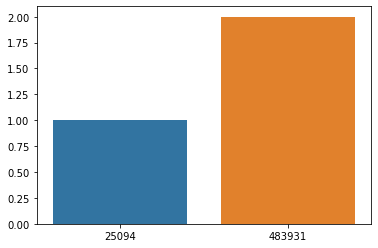

In [9]:
_ = customer_data['Title'].value_counts()
sns.barplot(x=_.values, y=_.index)

* The <code>Title</code> only contains <code>['Mr.', 'Mrs.']</code>. <code>['Company', 'Mr. and Mrs.']</code> weren't found.
* They have an imbalanced distribution.
* There seems to be no features that would aid in predicting the <code>Title</code> before merging.

In [10]:
titles = ['Mr.', 'Mrs.']
customer_data['Title'] = np.where(customer_data['Title'].isnull(),
                         titles[math.floor(random.random()*((483931 + 25094)/483931))], 
                         customer_data['Title'])

* All values in `customer_data` have been imputed.

In [11]:
customer_data['Business Partner'].nunique()
len(customer_data)

555202

555202

In [12]:
customer_data['Customer No.'].nunique()
len(customer_data)

555202

555202

* <code>['Customer No.', 'Business Partner']</code> seem to be some sort of identifiers for internal and external systems.
* Both contain all unique values with no repetition.
* They do not offer any prediction power, but may aid in merging.

In [13]:
customer_data = pd.get_dummies(customer_data, columns=['Partner Type', 'Data Origin', 'Title'])

In [14]:
customer_data.head()

,Business Partner,Customer No.,Partner Type_1.0,Partner Type_2.0,Partner Type_3.0,Partner Type_4.0,Partner Type_9001.0,Partner Type_9002.0,Partner Type_9003.0,Data Origin_Z001,...,Data Origin_Z016,Data Origin_Z017,Data Origin_Z018,Data Origin_Z019,Data Origin_Z020,Data Origin_Z021,Data Origin_Z022,Title_1.0,Title_2.0,Title_Mr.
0,31,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,32,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,34,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,35,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,42,7,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Invoice

In [15]:
missing_df = check_null(invoice)
missing_df

Total Columns: 492314


,Number_Missing,% Missing,Missing?
Service Advisor Name,492314,100.000000,True
Claim No.,487510,99.024200,True
Policy no.,475432,96.570888,True
Expiry Date,470083,95.484386,True
Insurance Company,468723,95.208140,True
Cash /Cashless Type,464894,94.430384,True
Gate Pass Date,451399,91.689247,True
Technician Name,236834,48.106290,True
Total IGST,197286,40.073205,True
Total GST,197286,40.073205,True


In [16]:
recurring_df = check_recurring(invoice)
recurring_df

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
1,Amt Rcvd From Custom,1,295028,0.000003,True
2,Amt Rcvd From Ins Co,1,295028,0.000003,True
4,CGST(14%),1,295028,0.000003,True
5,CGST(2.5%),1,295028,0.000003,True
6,CGST(6%),1,295028,0.000003,True
7,CGST(9%),1,295028,0.000003,True
17,IGST(12%),1,295028,0.000003,True
18,IGST(18%),1,295028,0.000003,True
19,IGST(28%),1,295028,0.000003,True
20,IGST(5%),1,295028,0.000003,True


In [17]:
columns_to_drop = set()

# more than 90% missing values
for i in list(missing_df[missing_df['% Missing']>90].index):
    columns_to_drop.add(i)

# columns that have just a single value
for i in list(recurring_df[ recurring_df['Unique Values']==1]['Column']):
    columns_to_drop.add(i)

# dropping the columns
invoice.drop(columns=list(columns_to_drop), axis=1, inplace=True)

In [18]:
# dropping records where missing values are low
# not dropping `Model` as it may provide predictive power in areas with less data
invoice.drop(invoice[ invoice['Regn No'].isnull() | invoice['CITY'].isnull()].index,
             axis=0, inplace=True)

In [19]:
check_null(invoice)

Total Columns: 492297


,Number_Missing,% Missing,Missing?
Technician Name,236822,48.105514,True
ODN No.,197282,40.073777,True
Total Value,197282,40.073777,True
Area / Locality,23889,4.852559,True
Model,1524,0.309569,True


* Now the remaining fields <code>['Technician Name', 'Total Value', 'ODN No.']</code> remain with significant missing values.
* <code>Technician Name</code> may later prove useful for Customer Prediction.
* <code>ODN No.</code> contains unique values apart from those missing. It doesn't give much else information and doesn't seem to be of use for any other tasks. Will drop it.
* <code>Total Value</code> contains the values same as <code>Total Amt Wtd Tax.</code>, hence will be dropping it as well.

In [20]:
invoice.drop(columns=['Total Value', 'ODN No.'], axis=1, inplace=True)

In [21]:
invoice['Technician Name'].fillna(value='Missing', inplace=True)

In [22]:
check_null(invoice)

Total Columns: 492297


,Number_Missing,% Missing,Missing?
Area / Locality,23889,4.852559,True
Model,1524,0.309569,True


* Since the customer segmentation needs to be carried out on their geological location, the 4.8% missing values in `['Area / Locality']` needs to be imputed.
* This will be done using the <code>District</code> column and <code>Plant Master</code> data.

In [23]:
def clean_and_add_values(plant_property):
    property_index = []
    property_value_counts = plant_property.value_counts()
    if type(property_value_counts.index[0]) == str:
        property_index = [ x.lower() for x in list(property_value_counts.index)] 
    else:
        property_index = list(property_value_counts.index)
        
    property_values = list(property_value_counts.values)
    
    property_index_set = set(property_index)
    
    # if there's more than one value
    if len(property_index_set) > 1:
        # find the occurences of all the different values' case occurrences
        for i in property_index_set:
            property_index_occurences = [k for k, x in enumerate(property_index) if x == i]
            if len(property_index_occurences) > 1:
                # add multiple occurences of different case values
                for j in range(1, len(property_index_occurences)):
                    property_values[property_index_occurences[0]] += property_values[j]
                    property_values[j] = 0
                    
    property_cleaned_and_added = pd.Series(data=property_values, index=property_value_counts.index)
    property_cleaned_and_added = property_cleaned_and_added.sort_values(ascending=False)
    
    property_decided_value = \
        property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[0]].index[0]
    
    chosen_index = 1
    if type(property_decided_value) == str:
        if len(property_decided_value.strip()) < 2:
            while( property_decided_value in [',', '.', '..', '...']):
                property_decided_value = \
                    property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[chosen_index]].index[0]
                chosen_index += 1
    return property_decided_value

In [24]:
plants = list( set(invoice['Plant']))
plants.sort()

In [25]:
final_invoice = invoice.copy()

for i in range(0, len(plants)):
    
    j = plants[i]
    properties_to_clean = ['CITY', 'Area / Locality', 'District', 'Pin code', 'Plant Name1']
    
    for property_ in properties_to_clean:
        cleaned_property = clean_and_add_values(final_invoice[ final_invoice['Plant'] == j ][property_])
        final_invoice[property_] = np.where(final_invoice['Plant'] == j, cleaned_property, final_invoice[property_])
        
    print(' '*40, end="")
    print("\r{0}% completed".format(np.around( i/len(plants)*100, decimals=2)), end="")
    print("                                            \r", end="")
print("\r                                            ", end="")
print("\r100% Complete")

100% Complete                                               


In [26]:
invoice = final_invoice.copy()

* Across the invoice data, the same <code>Regn No</code> comes up more than once, indicating that some frequent customers exist.
* The number of times a car has visited the shop may aid in segmentation.

In [27]:
# imputing car models using number plate data
for number_plate in list(invoice[ invoice['Model'].isnull() ]['Regn No']):
    car_records = invoice[ invoice['Regn No'] == number_plate][['Customer No.', 'Make', 'Model']]
    
    if len(car_records[ car_records['Model'].notnull() ]) >= 1:
        car_model_value_counts = car_records['Model'].value_counts().sort_values(ascending=False)
        invoice['Model'] = np.where(invoice['Regn No'] == number_plate,
                                      car_model_value_counts.index[0], 
                                      invoice['Model'])

* Further imputation would require manual input or random values. This may introduce noise in the data.
* Dropping the remaining values.

In [28]:
invoice.drop(invoice[ invoice['Model'].isnull() ].index, axis=0, inplace=True)

In [29]:
# attaching freguency of car Regn No and Customer No
invoice = attach_frequency(invoice, 'Regn No')
invoice = attach_frequency(invoice, 'Customer No.')

In [30]:
invoice.head()

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
0,0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5
1,1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6
2,2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3
3,3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6
4,4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8


In [31]:
# checking to see if there is any imbalanced in customer no and regn no frequency
# imbalance would mean a car was owned by different 
invoice[ invoice['Regn No_frequency'] > invoice['Customer No._frequency']]

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
261,261,THANE,THANE,Retail,E25519,Maharashtra,00:00:00,2015-01-30,7005200263,17:02:06,...,BC01,THANE,NO,0.0,MH04DN6210,SAMEER,1205.09,BC01SA1,52,11
292,292,PUNE,PUNE,Retail,68935,Maharashtra,00:00:00,2015-01-02,7006200007,17:23:54,...,BC02,PUNE,NO,0.0,MH12HY3999,umakant,299.92,BC02SA2,6,4
340,340,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200055,11:03:19,...,BC02,PUNE,NO,0.0,MH14CS4118,KIRAN,1002.18,BC02WM1,7,6
343,343,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200058,11:56:30,...,BC02,PUNE,NO,0.0,MH14CS4118,UMAKANT,0.00,BC02SA2,7,6
346,346,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200061,15:04:09,...,BC02,PUNE,NO,0.0,MH14CS4118,UMAKANT,419.74,BC02SA2,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490478,984330,RAMNAGAR,RAMNAGAR,Retail,202219,Uttarakhand,00:00:00,2016-06-28,7198600001,18:36:14,...,X243,X243 - JINDAL AUTOMOBILES,NO,0.0,UK04L4033,Missing,5702.70,X243SA1,3,2
490543,984395,NAMAKKAL,NAMAKKAL,Retail,198247,Tamil Nadu,00:00:00,2016-06-27,7199800098,19:23:38,...,X249,X249 - AMBUJA'S AUTOMOTIVES,NO,0.0,TN02AF9596,Missing,99.14,X249SA1,4,3
490557,984409,NAMAKKAL,NAMAKKAL,Retail,201671,Tamil Nadu,00:00:00,2016-06-28,7199800112,19:25:45,...,X249,X249 - AMBUJA'S AUTOMOTIVES,NO,0.0,TN28AC1810,Missing,99.14,X249SA1,2,1
490704,984556,SURAT,SURAT,Retail,195577,Gujarat,00:00:00,2016-06-30,7205801297,14:51:03,...,X279,X279 - J B CAR CARE,NO,0.0,GJ5JK0011,Missing,599.14,X279WM1,3,2


* There exist cars that have been owned by 2 or more known customers

In [32]:
invoice['Pre-owned_by_Known'] = (invoice['Regn No_frequency'] > invoice['Customer No._frequency']).astype(int)

In [33]:
invoice.head()

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known
0,0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5,0
1,1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6,0
2,2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3,0
3,3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6,0
4,4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8,0


* Appending known previous owner's customer numbers

In [34]:
def occurrences_a_wrt_b(a, b, df, name):
    '''
    Finds occurrences of "A" with respect to occurences of "B".
    Appends counts of occurrences and a string separated by
    commas and returns the resultant DataFrame.
    !Pass DataFrame with a standard index!
    '''
    b_to_a = {}
    
    # using a dictionary to store occurreces of b using sets
    # using value of b as key
    for indice in df.index:
        try:
            b_to_a[df.at[indice, b]].add(df.at[indice, a])
        except:
            b_to_a[df.at[indice, b]] = set([invoice.at[indice, a]])
    
    # storing counts of occurrences using b_to_a
    b_to_a_counts = {}
    
    for key in b_to_a.keys():
        b_to_a_counts[key] = len(b_to_a[key])
    
    # converting the different occurences of `a` to string separated with comma
    for key in b_to_a.keys():
        if len(b_to_a[key]) == 1:
            b_to_a[key] = list(b_to_a[key])[0]
        else:
            b_to_a[key] = ', '.join([j for j in b_to_a[key]])
        
    df.set_index(b, inplace=True)
    
    df[name] = pd.Series(b_to_a)
    df[f'{name} Count'] = pd.Series(b_to_a_counts)
    df.reset_index(inplace=True)
    
    return df

In [35]:
invoice = occurrences_a_wrt_b(a='Plant', b='Customer No.', df=invoice, name='Plants visited by Customer')
invoice.head()

,Customer No.,Unnamed: 0,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count
0,67849,0,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5,0,BC01,1
1,84419,1,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6,0,BC01,1
2,81055,2,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3,0,BC01,1
3,84419,3,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6,0,BC01,1
4,18980,4,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8,0,BC01,1


(0.0, 400000.0)

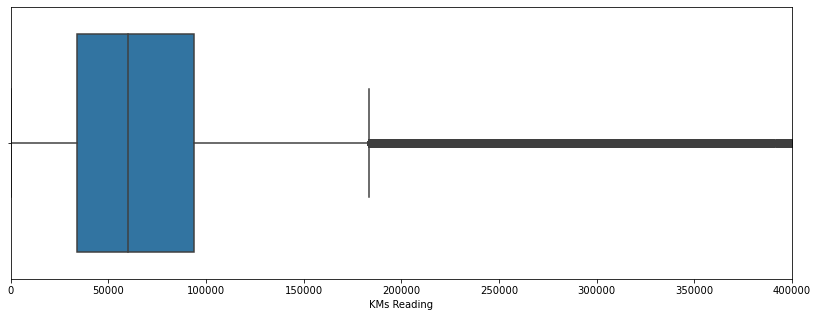

In [36]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_xlim(0, 400000)
sns.boxplot(invoice['KMs Reading'])

(0.0, 1.1000000000000001e-05)

(0.0, 1.1000000000000001e-05)

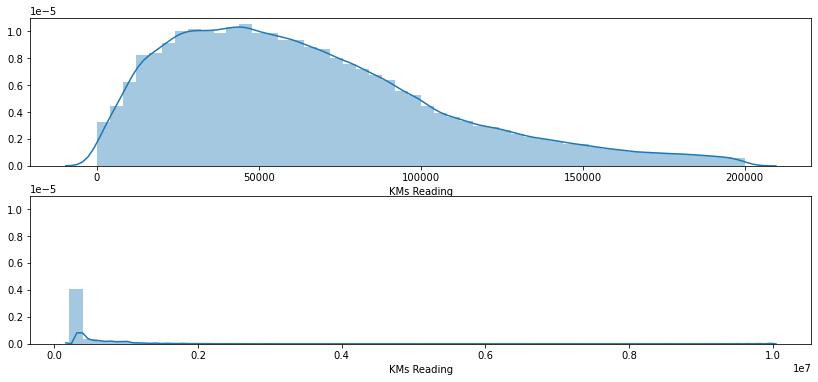

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 6))
ax[0].set_ylim(0, 1.1*1e-5)
ax[1].set_ylim(0, 1.1*1e-5)

sns.distplot(invoice[invoice['KMs Reading'] <= 200000]['KMs Reading'], ax=ax[0])
sns.distplot(invoice[invoice['KMs Reading'] > 200000]['KMs Reading'], ax=ax[1])

In [39]:
invoice = occurrences_a_wrt_b(a='Plant', b='Regn No', df=invoice, name='Plants visited by Car')
invoice.head()

,Regn No,Customer No.,Unnamed: 0,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,...,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count,Plants visited by Car,Plants visited by Car Count
0,KA19MA1291,67849,0,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,...,RUPESH,4051.95,BC01FS1,5,5,0,BC01,1,BC01,1
1,MH43R3046,84419,1,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,...,PRASHANT,1001.29,BC01SA2,6,6,0,BC01,1,BC01,1
2,AP09AX0582,81055,2,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,...,IMRAN,233.14,BC01SA2,3,3,0,BC01,1,BC01,1
3,MH43R3046,84419,3,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,...,PRASHANT,0.00,BC01SA2,6,6,0,BC01,1,BC01,1
4,MH04CD9768,18980,4,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,...,DAYANAND,2747.12,BC01SA2,8,8,0,BC01,1,BC01,1


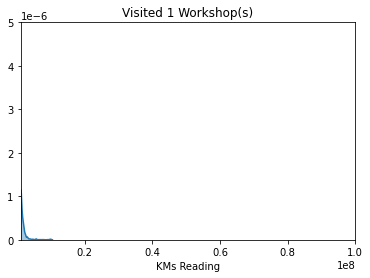

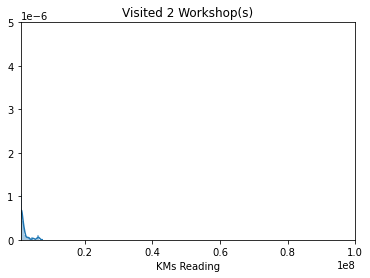

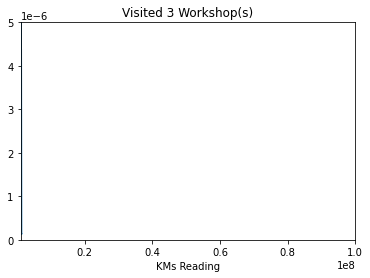

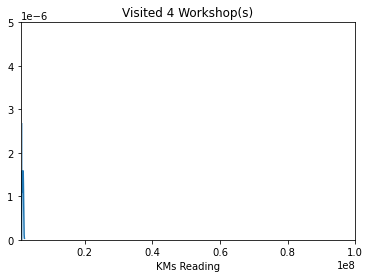

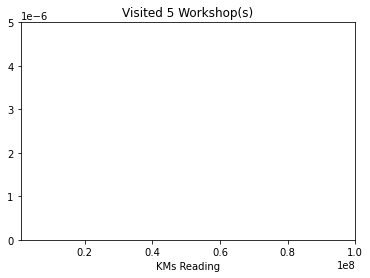

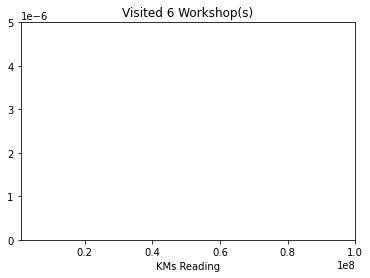

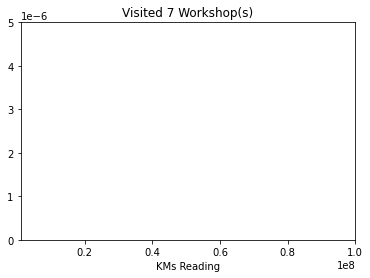

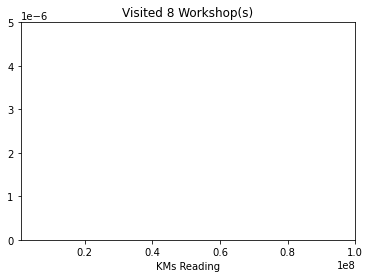

In [40]:
for count in invoice['Plants visited by Car Count'].unique():
    mask = (invoice['Plants visited by Car Count'] == count) \
            & (invoice['KMs Reading'] > 200000)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    _ = ax.set_xlim(200000, 100000000)
    _ = ax.set_ylim(0, 0.5*1e-5)
    _ = sns.distplot(invoice[ mask ]['KMs Reading'])
    _ = plt.title(f'Visited {count} Workshop(s)')
    _ = plt.show()

In [41]:
invoice = occurrences_a_wrt_b(a='Customer No.', b='Regn No', df=invoice, name='Vehicle Owner')
invoice.head()

,Regn No,Customer No.,Unnamed: 0,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,...,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count,Plants visited by Car,Plants visited by Car Count,Vehicle Owner,Vehicle Owner Count
0,KA19MA1291,67849,0,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,...,BC01FS1,5,5,0,BC01,1,BC01,1,67849,1
1,MH43R3046,84419,1,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,...,BC01SA2,6,6,0,BC01,1,BC01,1,84419,1
2,AP09AX0582,81055,2,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,...,BC01SA2,3,3,0,BC01,1,BC01,1,81055,1
3,MH43R3046,84419,3,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,...,BC01SA2,6,6,0,BC01,1,BC01,1,84419,1
4,MH04CD9768,18980,4,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,...,BC01SA2,8,8,0,BC01,1,BC01,1,18980,1


In [42]:
invoice = occurrences_a_wrt_b(a='Regn No', b='Customer No.', df=invoice, name='Cars Owned')
invoice.head()

,Customer No.,Regn No,Unnamed: 0,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,...,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count,Plants visited by Car,Plants visited by Car Count,Vehicle Owner,Vehicle Owner Count,Cars Owned,Cars Owned Count
0,67849,KA19MA1291,0,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,...,5,0,BC01,1,BC01,1,67849,1,KA19MA1291,1
1,84419,MH43R3046,1,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,...,6,0,BC01,1,BC01,1,84419,1,MH43R3046,1
2,81055,AP09AX0582,2,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,...,3,0,BC01,1,BC01,1,81055,1,AP09AX0582,1
3,84419,MH43R3046,3,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,...,6,0,BC01,1,BC01,1,84419,1,MH43R3046,1
4,18980,MH04CD9768,4,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,...,8,0,BC01,1,BC01,1,18980,1,MH04CD9768,1


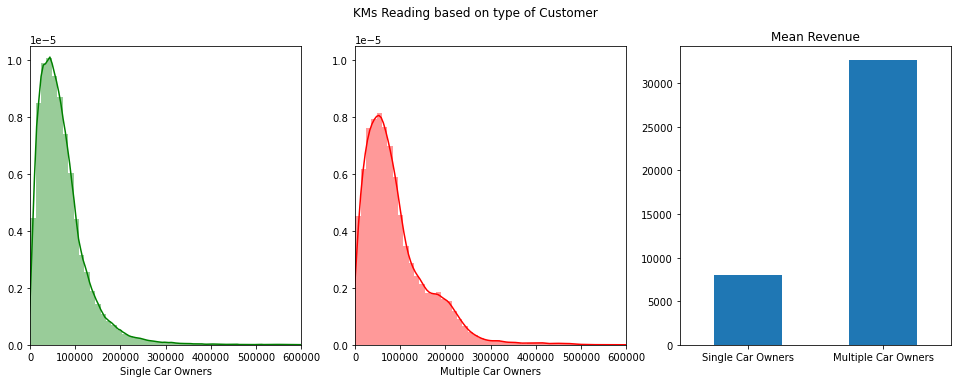

In [43]:
height = 5.5
width = 3*height
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
_ = fig.suptitle('KMs Reading based on type of Customer')

_ = ax[0].set_xlim(0, 600000)
_ = ax[0].set_ylim(0, 1.05*1e-5)
_ = ax[1].set_xlim(0, 600000)
_ = ax[1].set_ylim(0, 1.05*1e-5)

mask = (invoice['Cars Owned Count'] == 1) \
        & (invoice['KMs Reading'] < 600000)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
             axlabel='Single Car Owners', 
             color='Green', 
             ax=ax[0])

mask = (invoice['Cars Owned Count'] > 1) \
        & (invoice['KMs Reading'] < 600000)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
             axlabel='Multiple Car Owners', 
             color='Red',
             ax=ax[1])
# plt.show()

_ = []

mask = invoice['Cars Owned Count'] == 1
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

mask = invoice['Cars Owned Count'] > 1
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

_ = pd.Series(_, index=['Single Car Owners', 'Multiple Car Owners']) \
        .plot(kind='bar', ax=ax[2], title='Mean Revenue')
_ = plt.xticks(rotation=0)

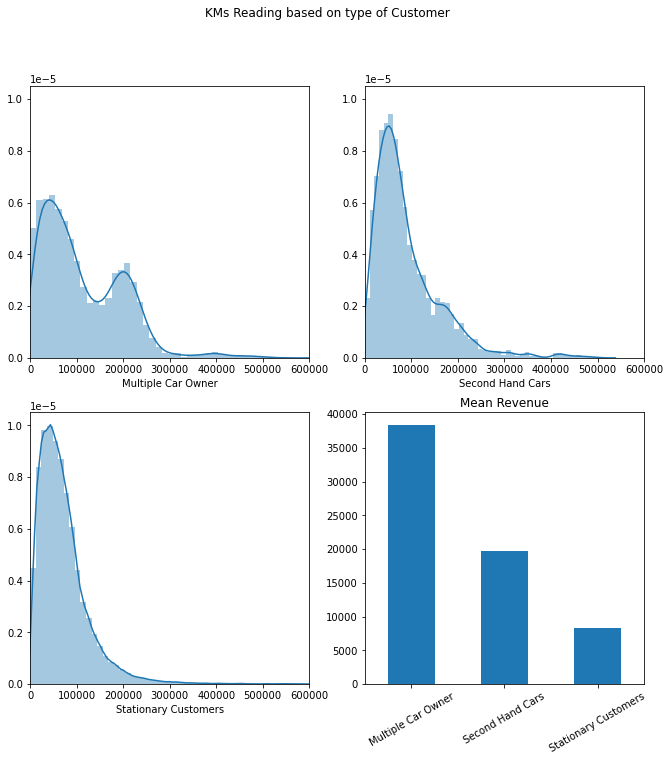

In [44]:
height = 11
width = 11

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(width, height))
_ = fig.suptitle('KMs Reading based on type of Customer')

for i, ax_ in enumerate(ax.ravel()):
    if i == 3:
        continue
    _ = ax_.set_xlim(0, 600000)
    _ = ax_.set_ylim(0, 1.05*1e-5)

mask = (invoice['Plants visited by Car'] < invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
                 ax=ax[0][0], 
                 axlabel='Multiple Car Owner',)

mask = (invoice['Plants visited by Car'] > invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
                 ax=ax[0][1], 
                 axlabel='Second Hand Cars',)

mask = (invoice['Plants visited by Car'] == invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
                 ax=ax[1][0], 
                 axlabel='Stationary Customers',)

_ = []

mask = (invoice['Plants visited by Car'] < invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

mask = (invoice['Plants visited by Car'] > invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

mask = (invoice['Plants visited by Car'] == invoice['Plants visited by Customer']) \
        & (invoice['KMs Reading'] < 600000)
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

_ = pd.Series(_, index=['Multiple Car Owner', 'Second Hand Cars', 'Stationary Customers']) \
        .plot(kind='bar', ax=ax[1][1], title='Mean Revenue')
_ = plt.xticks(rotation=30)

In [45]:
# regno_to_customer = {}

# for indice in invoice.index:
#     try:
#         regno_to_customer[invoice.at[indice, 'Regn No']].add(invoice.at[indice, 'Customer No.'])
#     except:
#         regno_to_customer[invoice.at[indice, 'Regn No']] = set([invoice.at[indice, 'Customer No.']])

# regno_to_customer_counts = {}

# for key in regno_to_customer.keys():
#     regno_to_customer_counts[key] = len(regno_to_customer[key])

# for key in regno_to_customer.keys():
#     if len(regno_to_customer[key]) == 1:
#         regno_to_customer[key] = list(regno_to_customer[key])[0]
#     else:
#         regno_to_customer[key] = ', '.join([j for j in regno_to_customer[key]])

# invoice.set_index('Regn No', inplace=True)
# invoice['Car Owners'] = pd.Series(regno_to_customer)
# invoice['Car Owners Count'] = pd.Series(regno_to_customer_counts)
# invoice.reset_index(inplace=True)
# invoice.head()

#### Cleaning ['JobCard Date', 'JobCard Time', 'Invoice Date', 'Invoice Time', 'Gate Pass Time']

In [46]:
from datetime import datetime
from datetime import timedelta

In [47]:
def convert_to_datetime(item):
    try:
        return datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
    except:
        print("Couldn't parse: {0}".format(item))
        assert False

In [48]:
invoice['JobCard DateTime'] = invoice['JobCard Date'] + " " + invoice['JobCard Time']
invoice['JobCard DateTime'] = invoice['JobCard DateTime'].apply(convert_to_datetime)

In [49]:
invoice['Gate Pass DateTime'] = invoice['JobCard Date'] + " " + invoice['Gate Pass Time']
invoice['Gate Pass DateTime'] = invoice['Gate Pass DateTime'].apply(convert_to_datetime)

In [50]:
invoice['Invoice DateTime'] = invoice['Invoice Date'] + " " + invoice['Invoice Time']
invoice['Invoice DateTime'] = invoice['Invoice DateTime'].apply(convert_to_datetime)

In [51]:
invoice['Total Time in seconds'] = invoice['Invoice DateTime'] - invoice['JobCard DateTime']
invoice['Total Time in seconds'] = invoice['Total Time in seconds'].apply(timedelta.total_seconds)

In [52]:
invoice.drop(invoice[ invoice['Total Time in seconds'] <= 0].index, axis=0, inplace=True)

In [53]:
invoice['Total time in days'] = invoice['Total Time in seconds']//(60*60*24)

In [54]:
invoice['Response Time in seconds'] = invoice['Gate Pass DateTime'] - invoice['JobCard DateTime']
invoice['Response Time in seconds'] = invoice['Response Time in seconds'].apply(timedelta.total_seconds)

In [55]:
invoice['Response Time in seconds'] = np.where(invoice['Response Time in seconds'] < 0, 
                                               invoice['Response Time in seconds'] + 60*60*24,
                                               invoice['Response Time in seconds'])

In [56]:
invoice['Response time in hours'] = invoice['Response Time in seconds']/(60*60)
invoice['Response time in days'] = invoice['Response Time in seconds']//(60*60*24)

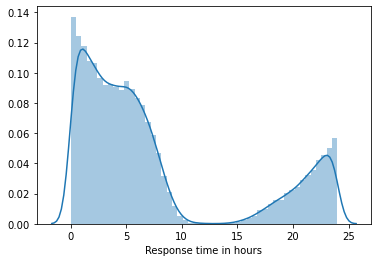

In [57]:
# plotting distrivution of response time
mask = (invoice['Gate Pass Time'] != "00:00:00")
sns.distplot(invoice[mask]['Response time in hours'])

* The curve is U-shaped due to the fact that most workshops are closed during the night. Customers drop their cars during a comfortable time period.
* Let's plot the time when cars are dropped in.

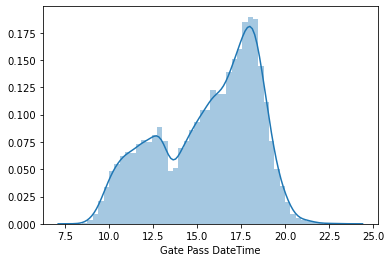

In [58]:
def get_seconds(dt_time):
#     x.to_pydatetime().time().hour * 60 + x.to_pydatetime().time().minute) * 60 + x.to_pydatetime().time().second
    hours = dt_time.to_pydatetime().time().hour * 60 * 60
    minutes = dt_time.to_pydatetime().time().minute * 60
    seconds = dt_time.to_pydatetime().time().second
    return hours + minutes + seconds

sns.distplot(invoice[mask]['Gate Pass DateTime'].apply(lambda x: get_seconds(x)/3600))

* Customers are more likely to drop their cars in the workshops in the evenings.
* A dip around 2 pm is observed, which may be due to lunch time in some workshops or customers not wanting to drop cars during that time.

### Plotting time taken in days for jobs

<Figure size 576x288 with 0 Axes>

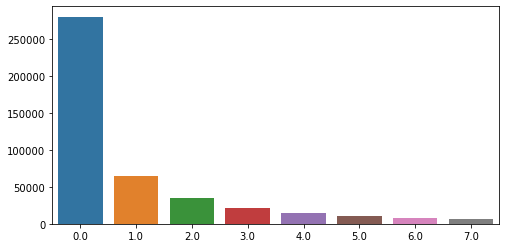

In [59]:
mask = invoice['Total time in days'] <= 7

_ = invoice[mask]['Total time in days'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=_.index, y=_.values)

In [60]:
invoice[ invoice['Gate Pass Time'] != '00:00:00' ][['JobCard Date', 'JobCard Time', 'Invoice Date', 'Invoice Time', 'Gate Pass Time']].head()

,JobCard Date,JobCard Time,Invoice Date,Invoice Time,Gate Pass Time
5676,2015-01-28,11:07:47,2015-01-28,13:18:59,17:50:23
9558,2015-02-05,18:26:31,2015-02-07,19:44:54,11:14:15
10406,2014-12-13,11:19:00,2015-02-28,17:24:52,11:55:58
13982,2015-02-10,14:46:46,2015-02-10,16:18:52,18:16:21
18673,2015-03-31,20:45:10,2015-03-31,21:50:27,21:03:14


#### Looking for customers who have visited different service centers

In [61]:
_ = invoice.groupby(['Customer No.'])

In [62]:
df = (_['Plant']).value_counts().sort_index().to_frame()

df.columns = ['Visits']
df.reset_index(inplace=True)
df.head()

,Customer No.,Plant,Visits
0,1,BC02,4
1,10,BC01,5
2,100,BC11,2
3,1000,BC02,6
4,10000,BC05,7


In [63]:
vc = df['Customer No.'].value_counts()
multi_plant_customers = list(vc[ vc>1 ].index)

In [64]:
# setting a boolean flag to check if a customer has visited other plants
invoice['Visited_Multiple_Plants'] = 0

invoice.set_index('Customer No.', inplace=True)

for cust_no in multi_plant_customers:
    invoice.at[cust_no, 'Visited_Multiple_Plants'] = 1
# multi_plant_customers

invoice.reset_index(inplace=True)

In [65]:
invoice.rename(columns={'District': 'State', 'CITY': 'City', 'Area / Locality': 'District'}, inplace=True)

#### JTD

In [66]:
jtd.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [67]:
jtd.head(1).T

,0
DBM Order,22385
Order Item,180
Material,OSLCC_SRV31
Labor Value Number,NaN
Description,MACHINING RR.SUSPENSION CHARGE (MAJOR)
Item Category,P010
Order Quantity,1.2
Target quantity UoM,MIN
Net value,1869.87


In [68]:
jtd['DBM Order'].nunique()
len(jtd)
jtd['DBM Order'].nunique() / len(jtd)

973473

5619484

0.17323174156203666

* `DBM Order` corresponds to the `Job Card No` in `Invoice`.
* Multiple entries in `JTD` mean that for most orders, multiple parts were used and each has been duly noted.

* `"SRV"` in `JTD['Material']` may refer to `Store Receipt Voucher`.

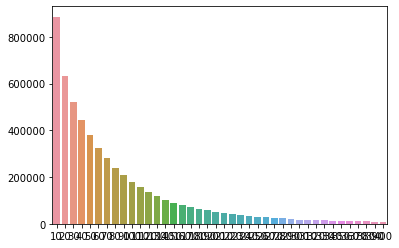

In [69]:
_ = jtd['Order Item'].value_counts().iloc[:40]

sns.barplot(x=_.index, y=_.values)
# set_x_tick_labels(multiples=50)

* Data in `Order Item` has an exponential distribution.

In [70]:
jtd['Item Category'].value_counts()

P002    3250293
P001    1845451
P011     343288
P010     128823
G2TX      51629
Name: Item Category, dtype: int64

In [71]:
jtd['Target quantity UoM'].value_counts()

EA     2745660
MIN    2317562
L       504597
GRO         36
Name: Target quantity UoM, dtype: int64

Seem to be 'Each', 'Minimum', 'Litre' and 'Gross'

<Figure size 864x432 with 0 Axes>

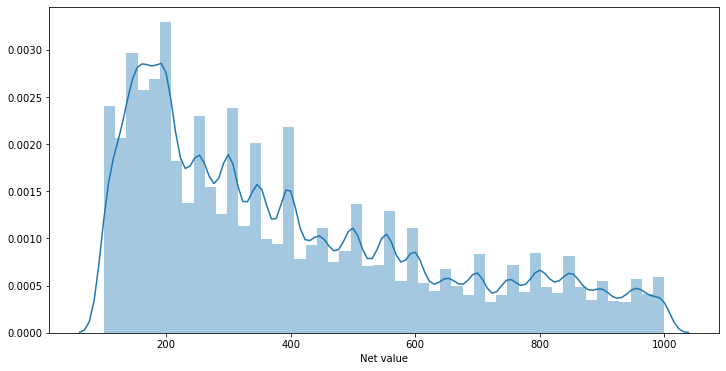

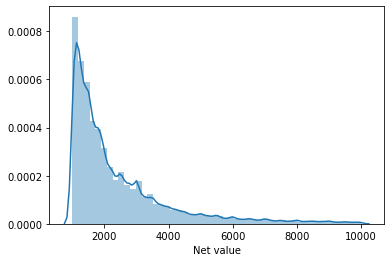

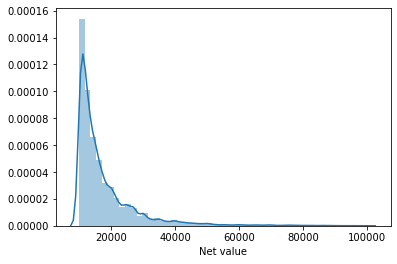

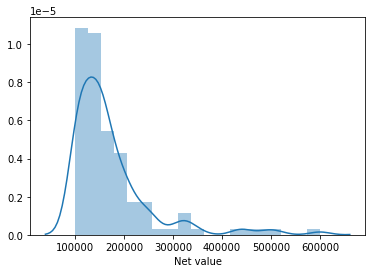

In [72]:
plt.figure(figsize=(12, 6))
sns.distplot(jtd[jtd['Net value'].between(100, 1000)]['Net value'])
plt.show()
sns.distplot(jtd[jtd['Net value'].between(1000, 10000)]['Net value'])
plt.show()
sns.distplot(jtd[jtd['Net value'].between(10000, 100000)]['Net value'])
plt.show()
sns.distplot(jtd[jtd['Net value'].between(100000, 1000000)]['Net value'])

* `Net value` has an exponential distribution. This may help in clustering the different kind of repairs.
* Data in `UoM` and `Order Quantity` is very dirty and due to no contextual aid, they will not be considered.
* Instead, `Net Value` will be used as a substitute wherever applicable.

### Revenue based on Plant

In [73]:
revenue_plant = {}

for plant in invoice['Plant'].unique():
    revenue_plant[plant] = invoice[invoice['Plant'] == plant]['Total Amt Wtd Tax.'].sum()

revenue_plant = pd.Series(revenue_plant)
revenue_plant.sort_values(ascending=False, inplace=True)

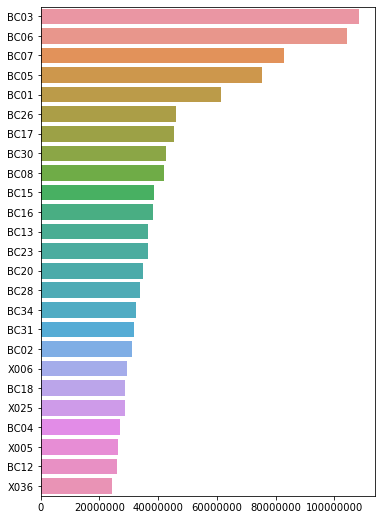

In [74]:
_ = plt.figure(figsize=(6, 9))

from_ = 0
to_ = from_ + 25

_ = sns.barplot(y=revenue_plant.iloc[from_:to_].index, 
                x=revenue_plant.iloc[from_:to_].values,
                orient='h')

_ = plt.ticklabel_format(style='plain', axis='x')

### Revenue based on State

In [75]:
revenue_state = {}

for state in invoice['State'].unique():
    revenue_state[state] = invoice[invoice['State'] == state]['Total Amt Wtd Tax.'].sum()

revenue_state = pd.Series(revenue_state)
revenue_state.sort_values(ascending=False, inplace=True)

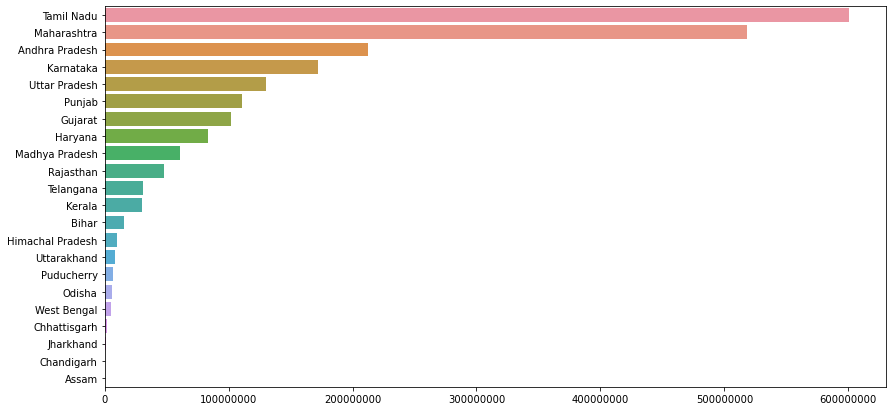

In [76]:
_ = plt.figure(figsize=(14, 7))

_ = sns.barplot(y=revenue_state.index, 
                x=revenue_state.values, 
                orient='h')

_ = plt.ticklabel_format(style='plain', axis='x')

### Mean revenue for plants in states

In [77]:
revenue_state_mean = revenue_state.copy()

for state in revenue_state_mean.index:
    revenue_state_mean[state] /= invoice[ invoice['State'] == state]['Plant'].nunique()

revenue_state_mean.sort_values(ascending=False, inplace=True)

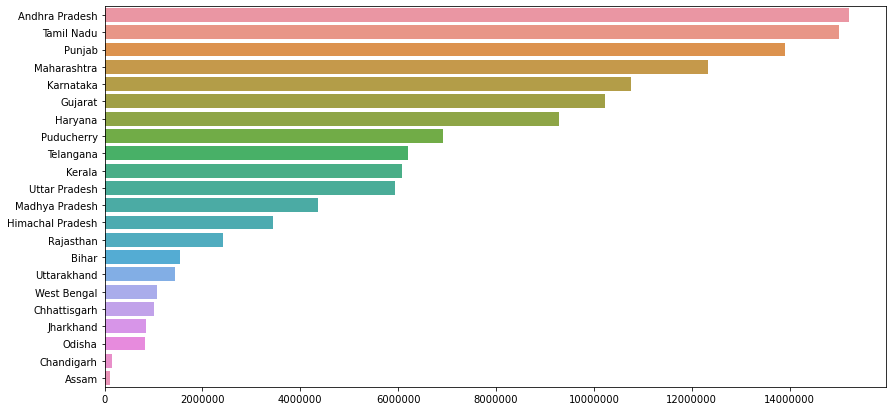

In [78]:
_ = plt.figure(figsize=(14, 7))

_ = sns.barplot(y=revenue_state_mean.index, 
                x=revenue_state_mean.values, 
                orient='h')

_ = plt.ticklabel_format(style='plain', axis='x')

In [79]:
stack_df = pd.DataFrame(np.zeros((242, 22)), 
                        index=invoice['Plant'].unique(), 
                        columns=invoice['State'].unique())

In [80]:
for plant in invoice['Plant'].unique():
    mask = (invoice['Plant'] == plant)
    state = invoice[mask]['State'].iloc[0]
    stack_df.at[plant, state] = invoice[mask]['Total Amt Wtd Tax.'].sum()

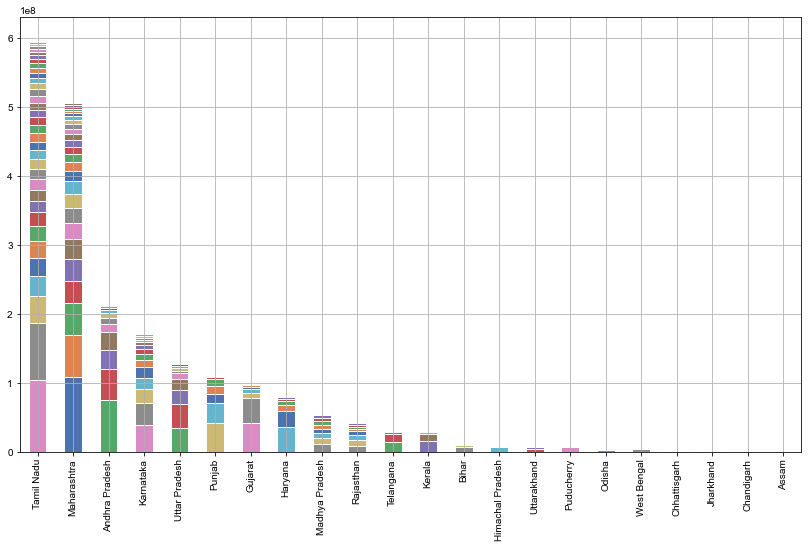

In [81]:
stack_df = stack_df.sort_values(by=[i for i in stack_df.columns], ascending=False)
order = revenue_state.index
fig, ax = plt.subplots(figsize=(14, 8))

sns.set()
stack_df.T.loc[order] \
                .plot(kind='bar', stacked=True, 
                      legend=False, ax=ax)

In [82]:
mask = invoice['KMs Reading'] <= 1000000
# invoice['']
invoice[mask][['Regn No', 'Make', 'Model', 'KMs Reading']].sort_values(by='KMs Reading').tail(20)

,Regn No,Make,Model,KMs Reading
438774,MH28V2619,TATA MOTORS,VENTURE,995244
269920,MH04Y9466,MARUTI SUZUKI,800,995326
30564,MH40A9431,MAHINDRA & MAHINDRA,SCORPIO CRDE,995541
106611,HR705503,MARUTI SUZUKI,800,996433
462934,KA35N732,FIAT,GRAND PUNTO,996608
462935,KA35N732,FIAT,GRAND PUNTO,996610
467845,KA35N732,FIAT,GRAND PUNTO,996611
220090,MH04DN8164,MAHINDRA & MAHINDRA,LOGAN P,997060
476082,RJ20CB9911,MARUTI SUZUKI,SWIFT,997358
225676,TN07AF6387,MAHINDRA & MAHINDRA,BOLERO,998460


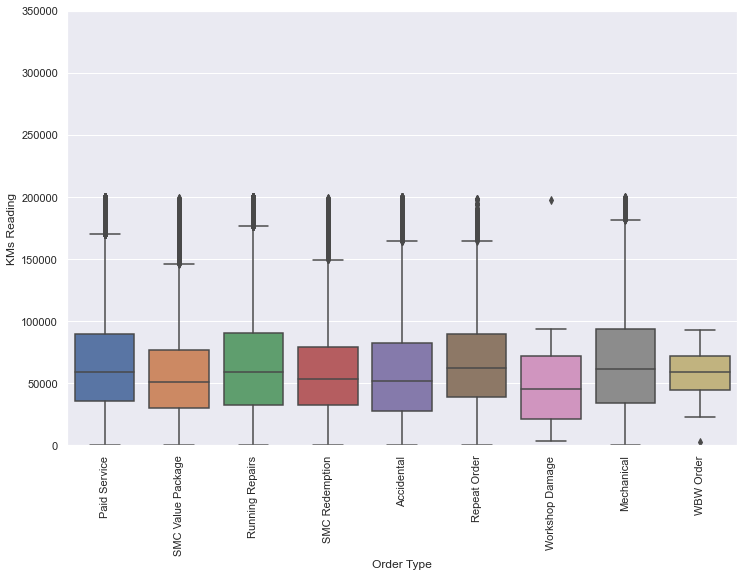

In [83]:
# KMs reading vs type of order

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# _ = ax_.set_xlim(0, 600000)
_ = ax.set_ylim(0, 350000)

mask = (invoice['KMs Reading'] < 200000)
_ = sns.boxplot(x='Order Type', y='KMs Reading', 
                   data=invoice[mask])

_ = plt.xticks(rotation=90)

(0.0, 40000.0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

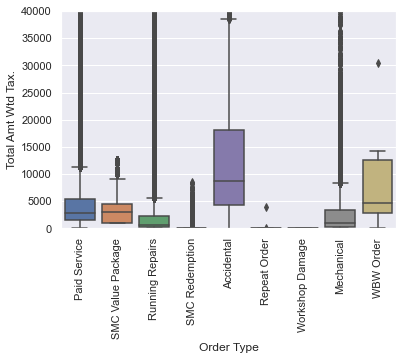

In [84]:
# Revenue based on type of order

fig, ax = plt.subplots()
ax.set_ylim(0, 40000)

sns.boxplot(x='Order Type', y='Total Amt Wtd Tax.', 
            data=invoice[invoice['KMs Reading'] < 200000], 
            ax=ax)
plt.xticks(rotation=90)

In [85]:
invoice['Is Old'] = (invoice['KMs Reading'] >= 200000).astype(int)

In [86]:
inv_jtd_inner = pd.merge(left=invoice, right=jtd, how='inner', left_on='Job Card No', right_on='DBM Order')

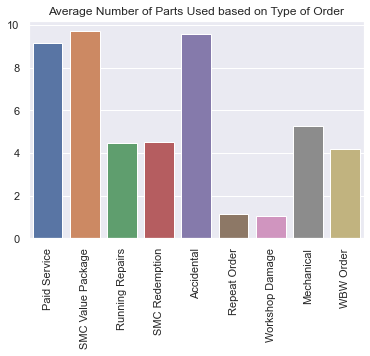

In [87]:
_ = []

for order in inv_jtd_inner['Order Type'].unique():
    mask = (inv_jtd_inner['Order Type'] == order)
    
    _.append(len(inv_jtd_inner[mask]) / inv_jtd_inner[mask]['Job Card No'].nunique())

_ = sns.barplot(x=inv_jtd_inner['Order Type'].unique(),
                y=_)
_ = plt.xticks(rotation=90)
_ = plt.title('Average Number of Parts Used based on Type of Order')

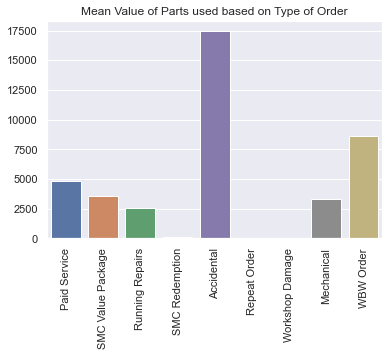

In [88]:
_ = []

for order in inv_jtd_inner['Order Type'].unique():
    mask = (inv_jtd_inner['Order Type'] == order)
    
    _.append(inv_jtd_inner[mask]['Net value'].sum() / inv_jtd_inner[mask]['Job Card No'].nunique())

_ = sns.barplot(x=inv_jtd_inner['Order Type'].unique(),
                y=_)
_ = plt.xticks(rotation=90)
_ = plt.title('Mean Value of Parts used based on Type of Order')

In [89]:
invoice['Revenue per hour'] = invoice['Total Amt Wtd Tax.'] / (invoice['Total Time in seconds']/3600)

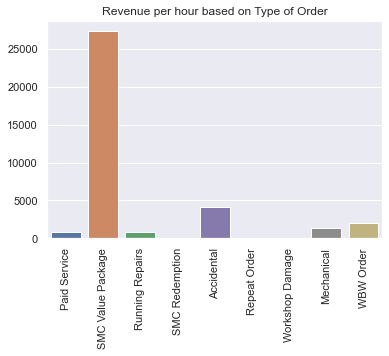

In [90]:
_ = []

for order in invoice['Order Type'].unique():
    mask = (invoice['Order Type'] == order)
    
    _.append(invoice[mask]['Revenue per hour'].sum() / invoice[mask]['Job Card No'].nunique())

_ = sns.barplot(x=invoice['Order Type'].unique(),
                y=_)
_ = plt.xticks(rotation=90)
_ = plt.title('Revenue per hour based on Type of Order')

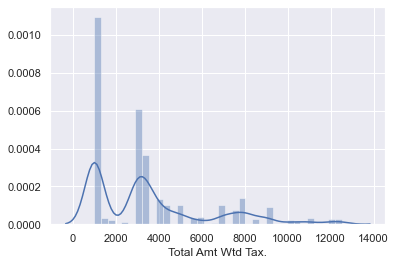

In [91]:
sns.distplot(invoice[invoice['Order Type'] == 'SMC Value Package']['Total Amt Wtd Tax.'])

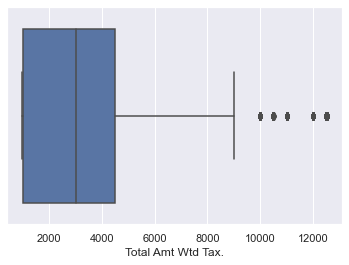

In [92]:
sns.boxplot(invoice[invoice['Order Type'] == 'SMC Value Package']['Total Amt Wtd Tax.'])

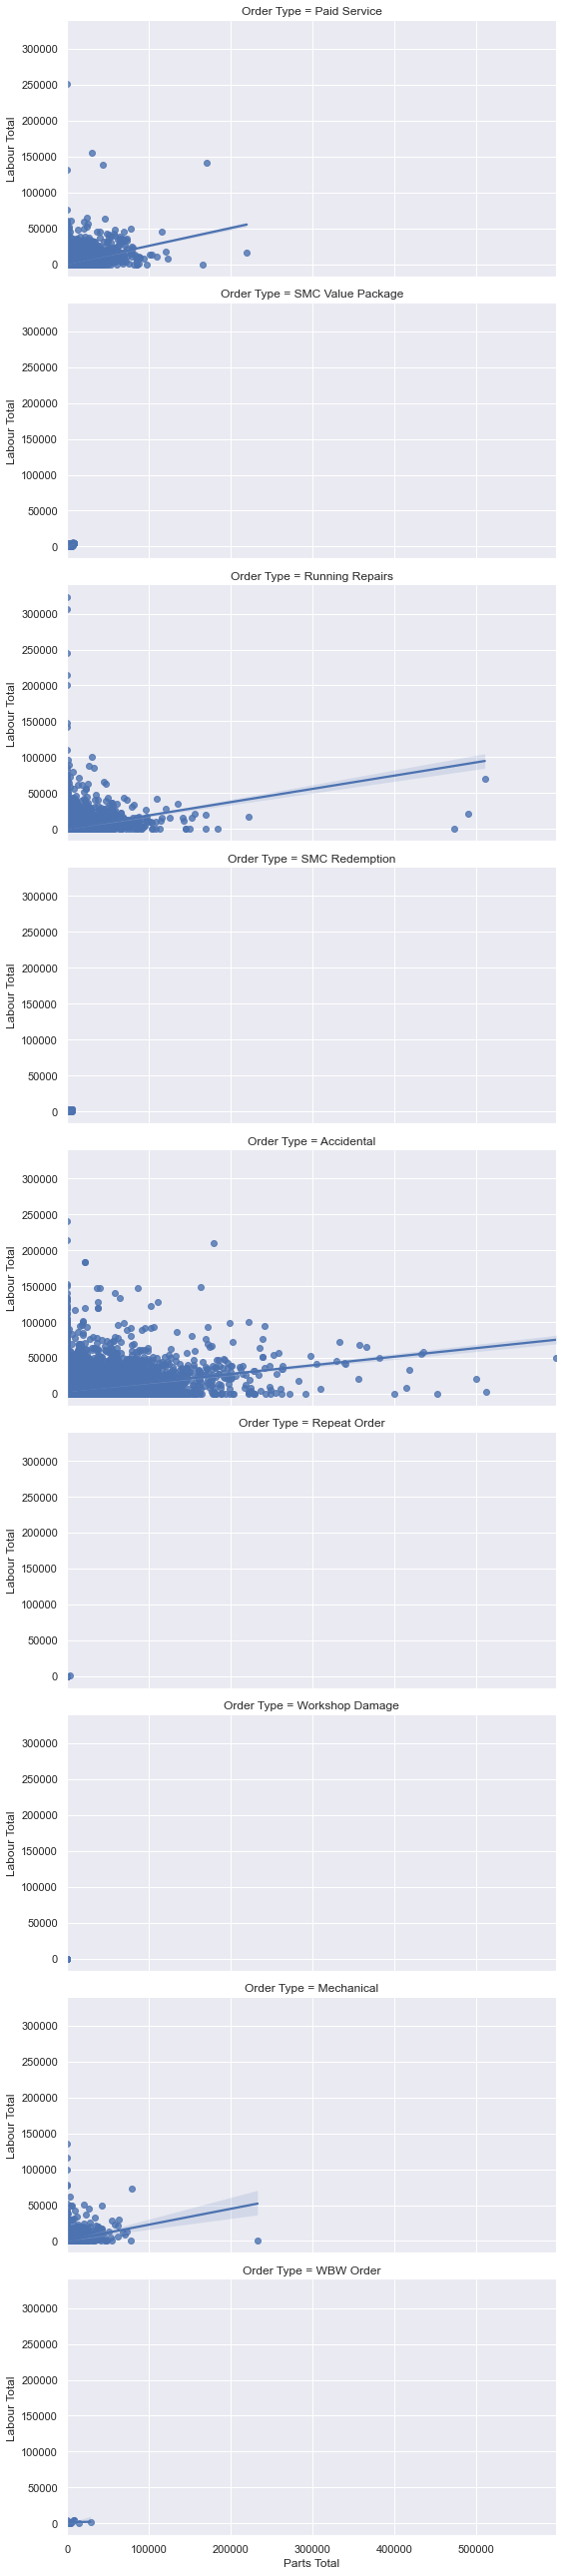

In [108]:
# checking if any relation exists between 'parts cost' and 'labour cost'

facet = sns.FacetGrid(invoice, row='Order Type', size=4, aspect=2)
figure = facet.map(sns.regplot, 'Parts Total', 'Labour Total')

* There's a clear positive correlation of parts with labour costs, but labour costs do not increase at the same scale as parts costs.

In [175]:
from itertools import product

df_parts_to_labour = pd.DataFrame(np.zeros((invoice['Make'].nunique(), invoice['Order Type'].nunique())), 
                                  columns=invoice['Order Type'].unique(), 
                                  index=invoice['Make'].unique())

for make, order in product(invoice['Make'].unique(), 
                           invoice['Order Type'].unique()):
    mask = (invoice['Make'] == make) & (invoice['Order Type'] == order)
    df_parts_to_labour.at[make, order] = invoice[mask]['Parts Total'].sum() / invoice[mask]['Labour Total'].sum()

df_parts_to_labour.fillna(0, inplace=True)
# df_parts_to_labour.head()

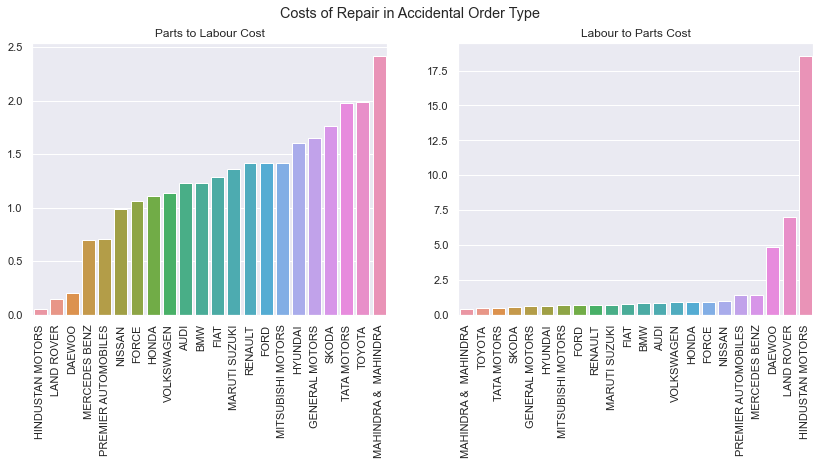

In [176]:
# Plotting Parts:Labour and Labour:Parts costs to understand favorable and unfavorable jobs

_ = df_parts_to_labour['Accidental'].sort_values()
_ = _[_>0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

fig_1 = sns.barplot(x=_.index, y=_.values, ax=ax[0])
__ = fig_1.set_xticklabels(labels=_.index, rotation=90)
__ = fig_1.set_title('Parts to Labour Cost')

_ = (1/_).sort_values()
fig_2 = sns.barplot(x=_.index, y=_.values, ax=ax[1])
__ = fig_2.set_xticklabels(labels=_.index, rotation=90)
__ = fig_2.set_title('Labour to Parts Cost')

__ = plt.suptitle('Costs of Repair in Accidental Order Type')

* From the graphs, it's observed that `Labour:Parts` costs is high in cases of luxury vehicles or old/obsolete vehicles.
* On the other hand, those with a higher `Parts:Labour` cost ratio are more lucrative due to lower labour costs.
* The trend was found to be the same when `Parts:Labour * Repair Time` was plotted.

In [206]:
invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.month_name()

0         December
1          January
2          January
3          January
4          January
            ...   
490883        June
490884        June
490885        June
490886        June
490887        June
Name: JobCard DateTime, Length: 490888, dtype: object

In [272]:
invoice['Year'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().year)
invoice['Month'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().month)
invoice['Month Name'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.month_name()
invoice['Day'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().day)
invoice['Day Name'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.day_name()
invoice['Hour'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().hour)

In [243]:
years = sorted(invoice['Year'].unique())
months = sorted(invoice['Month Name'].unique(), 
                        key=lambda x: invoice[invoice['Month Name']==x]['Month'].iloc[0])

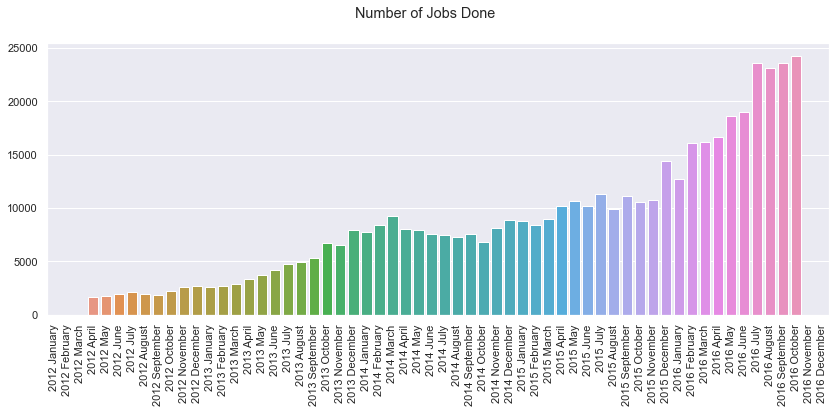

In [247]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Job Card No'].nunique())
        except:
            continue

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                         list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Number of Jobs Done')

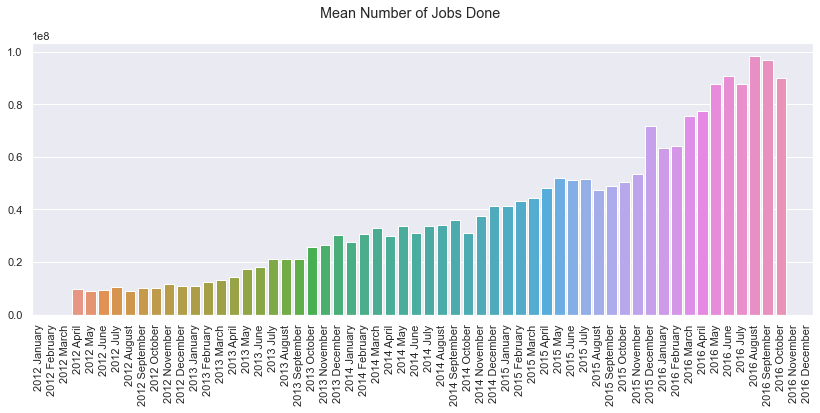

In [252]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Mean Number of Jobs Done')

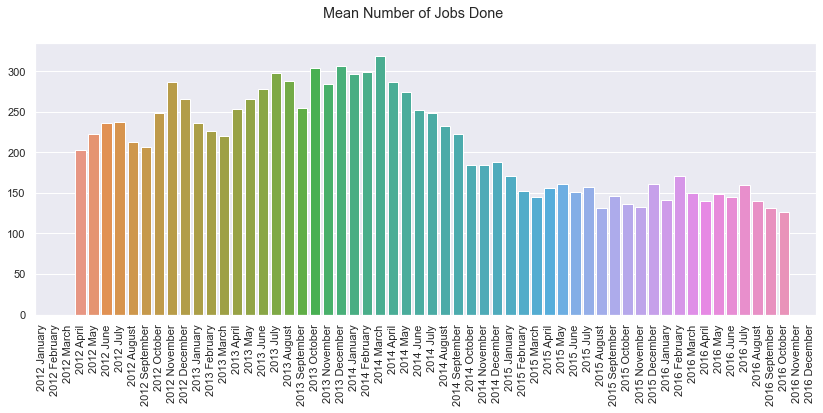

In [250]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Job Card No'].nunique() / invoice[mask]['Plant'].nunique())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Mean Number of Jobs Done')

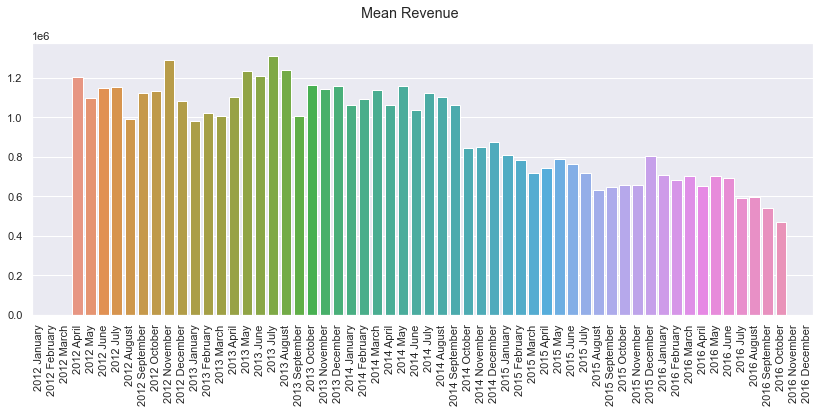

In [253]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Plant'].nunique())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Mean Revenue')

In [255]:
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

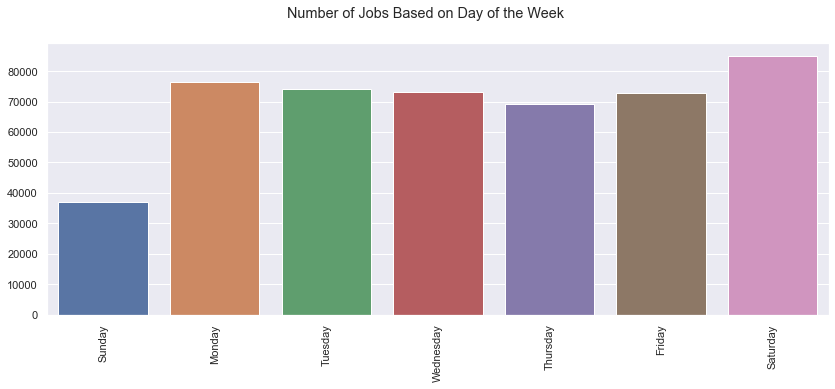

In [269]:
_ = []

for weekday in weekdays:
    try:
        mask = (invoice['Day Name'] == weekday)
        _.append(invoice[mask]['Job Card No'].nunique())
    except:
        _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=weekdays,
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Number of Jobs Based on Day of the Week')

* Day with most new customers is `Sturday` whereas the quietest day is `Thursday`.

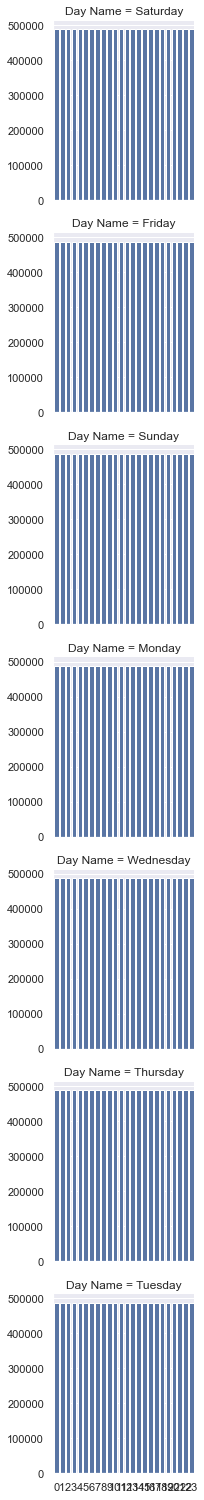

In [278]:
facet = sns.FacetGrid(data=invoice, row='Day Name')
fig_1 = facet.map(sns.barplot, x=invoice['Hour'], y=invoice['Job Card No'].nunique())

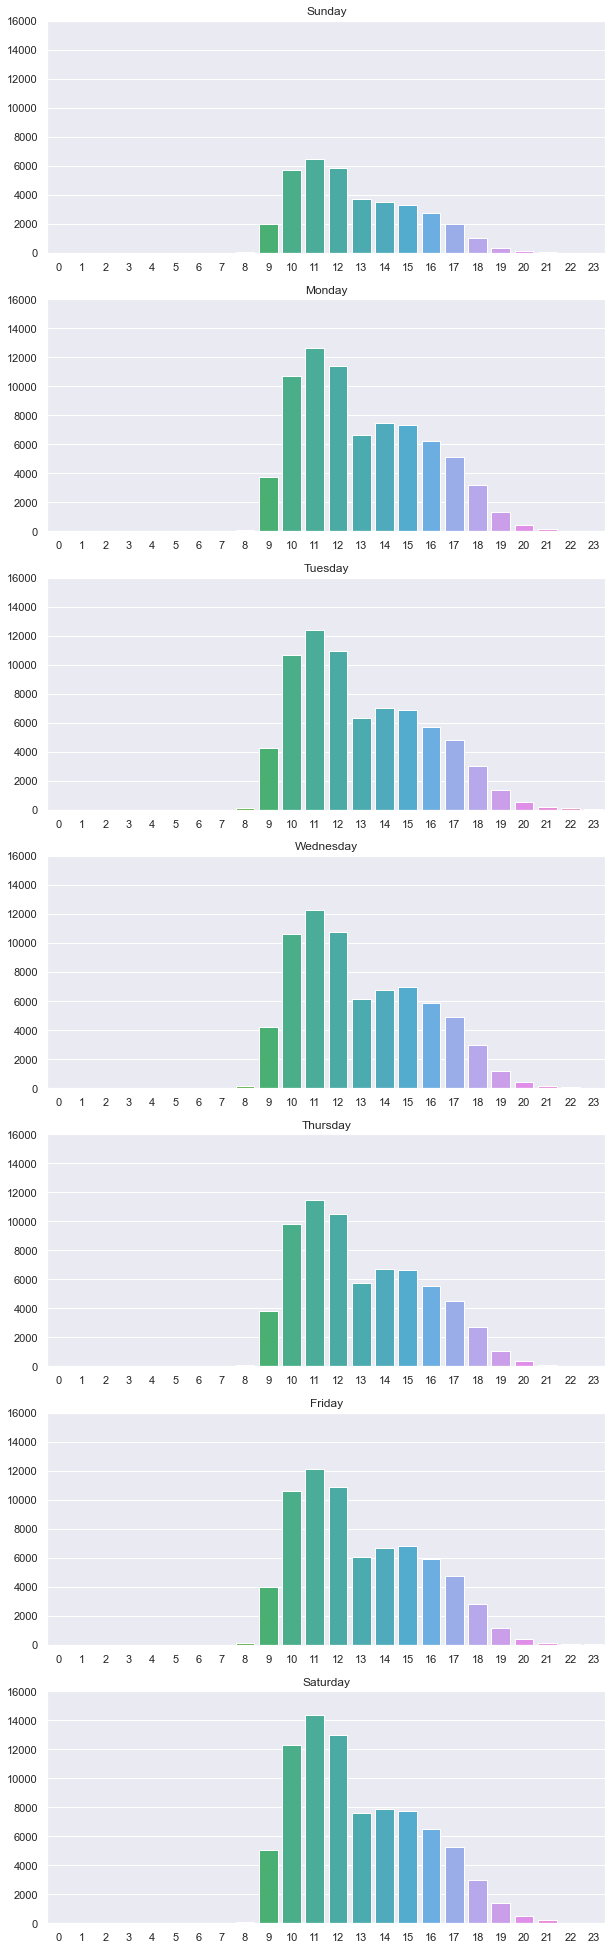

In [305]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))

for i, day in enumerate(weekdays):
    _ = []
    
    for hour in range(0, 24):
        try:
            mask = (invoice['Day Name'] == day) & (invoice['Hour'] == hour)
            _.append(invoice[mask]['Job Card No'].nunique())
        except:
            _.append(0)
    
    __ = ax[i].set_ylim(0, 16000)
    fig_1 = sns.barplot(x=list(range(0, 24)), y=_, ax=ax[i])
    __ = fig_1.set_title(day)